In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as LR

import torchvision
import torchvision.transforms as transforms

In [2]:
class NN(nn.Module):
    def __init__(self, layersize, eta=None):
        super(NN, self).__init__()
        
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))

    def forward(self, x):
        return x
    
    def update(self, u, v, eta=None):
        pass

class IP(nn.Module):
    def __init__(self, layersize, eta=1):
        super(IP, self).__init__()
        self.eta = eta
        
        # gain/bias are the learned output distribution params
#         self.gain = nn.Parameter(torch.ones(layersize))
#         self.bias = nn.Parameter(torch.zeros(layersize))
        
        # Alpha and beta are the ip normalization parameters
        self.register_buffer('alpha', torch.ones(layersize))
        self.register_buffer('beta', torch.zeros(layersize))
        
    def forward(self, x):

        # Normalize
        nx = (x-self.beta)/self.alpha

        return  nx
        
    def update(self, u, v, eta=None):

        if (eta is None):
            eta = self.eta
        
        with torch.no_grad():
            Ev = v.mean(0, keepdim=True)
            Euv = (u*v).mean(0, keepdim=True)

        self.alpha = (1-eta)*self.alpha + eta * 2*Euv
        self.beta = (1-eta)*self.beta + eta * (Ev)
#         for n in self.alpha:
#             for gain in n:
#                 if(gain != abs(gain)):
#                     print("FLAG!")
        
#         self.eta = eta * 0.999


class DNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(DNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(28*28, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 28*28)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [3]:
class CDNet(nn.Module):
    def __init__(self, layersize, norm=None, eta=1):
        super(CDNet, self).__init__()
        
        # Dense Layers
        self.fc1 = nn.Linear(3*32*32, layersize)
        self.fc2 = nn.Linear(layersize, layersize)
        self.fc3 = nn.Linear(layersize, layersize)
        self.fc4 = nn.Linear(layersize, layersize)
        self.fc5 = nn.Linear(layersize, layersize)
        self.fc6 = nn.Linear(layersize, layersize)
        self.fc7 = nn.Linear(layersize, layersize)
        self.fc8 = nn.Linear(layersize, layersize)
        self.fc9 = nn.Linear(layersize, 10)
        
        # Normalization Layers
        self.n1 = norm(layersize, eta)
        self.n2 = norm(layersize, eta)
        self.n3 = norm(layersize, eta)
        self.n4 = norm(layersize, eta)
        self.n5 = norm(layersize, eta)
        self.n6 = norm(layersize, eta)
        self.n7 = norm(layersize, eta)
        self.n8 = norm(layersize, eta)
        
    def forward(self, x, eta=None):
        x = x.view(-1, 3*32*32)
        u1 = self.fc1(x)
        v1 = F.tanh(self.n1(u1))
        u2 = self.fc2(v1)
        v2 = F.tanh(self.n2(u2))
        u3 = self.fc3(v2)
        v3 = F.tanh(self.n3(u3))
        u4 = self.fc4(v3)
        v4 = F.tanh(self.n4(u4))
        u5 = self.fc5(v4)
        v5 = F.tanh(self.n5(u5))
        u6 = self.fc6(v5)
        v6 = F.tanh(self.n6(u6))
        u7 = self.fc7(v6)
        v7 = F.tanh(self.n7(u7))
        u8 = self.fc8(v7)
        v8 = F.tanh(self.n8(u8))
        # Note you should not normalize after the last linear layer (you delete info)
        o = F.relu(self.fc9(v8))
        
        # Lets do the updates to the normalizations
        self.n1.update(u1, v1, eta)
        self.n2.update(u2, v2, eta)
        self.n3.update(u3, v3, eta)
        self.n4.update(u4, v4, eta)
        self.n5.update(u5, v5, eta)
        self.n6.update(u6, v6, eta)
        self.n7.update(u7, v7, eta)
        self.n8.update(u8, v8, eta)
        
        
        return o

In [4]:
def train_deep_model(network, optimization, seed, epochs):
    
    criterion = nn.CrossEntropyLoss()
    torch.manual_seed(seed)
    
    loss_tracker = []
    episode = 1
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        i = 0
        
        for i, data in enumerate(trainloader):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimization.zero_grad()

            # forward + backward + optimize
            y = network(inputs)
            loss = criterion(y, labels)
            loss.backward()
            optimization.step()

            # update statistics
            running_loss += loss.item()
            i += 0
            
            loss_tracker.append([episode,loss.item()])
            episode += 1
            
        print('[%d] loss: %.3f' %
                      (epoch + 1,running_loss / i))
        
    print("Largest beta is ", max(abs(network.n1.beta.max(0)[0]).max(0),
                   abs(network.n2.beta.max(0)[0]).max(0),
                   abs(network.n3.beta.max(0)[0]).max(0),
                   abs(network.n4.beta.max(0)[0]).max(0),
                   abs(network.n5.beta.max(0)[0]).max(0),
                   abs(network.n6.beta.max(0)[0]).max(0),
                   abs(network.n7.beta.max(0)[0]).max(0),
                   abs(network.n8.beta.max(0)[0]).max(0)))
    print("Largest weight is ", max(abs(network.fc1.weight.max(0)[0]).max(0),
              abs(network.fc2.weight.max(0)[0]).max(0),
              abs(network.fc3.weight.max(0)[0]).max(0),
              abs(network.fc4.weight.max(0)[0]).max(0),
              abs(network.fc5.weight.max(0)[0]).max(0),
              abs(network.fc6.weight.max(0)[0]).max(0),
              abs(network.fc7.weight.max(0)[0]).max(0),
              abs(network.fc8.weight.max(0)[0]).max(0)))
            
    print("Finished training!\n")
    return(np.transpose(loss_tracker))


def run_cifar_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = CDNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = CDNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = CDNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    
def run_mnist_experiment(int_lr, syn_lr, epochs, test_runs):
    seed = random.randint(0, 1000000)

    #Train IP Model
    torch.manual_seed(seed)
    IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
    IPnet = IPnet.to(device)

    optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
    print("Training IP Net. Run 1")
    ip_losses = train_deep_model(IPnet, optimizer1, seed, epochs)


    #Train Standard Model
    torch.manual_seed(seed)
    net = DNet(LAYERSIZE, NN, eta=int_lr)
    net = net.to(device)

    optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
    print("Training Standard Net. Run 1")
    standard_losses = train_deep_model(net, optimizer2, seed, epochs)

    for i in range(test_runs-1):
        seed = random.randint(0, 1000000)

        #Train IP Model
        torch.manual_seed(seed)
        IPnet = DNet(LAYERSIZE, IP, eta=int_lr)
        IPnet = IPnet.to(device)

        optimizer1 = optim.Adam(IPnet.parameters(), lr=syn_lr)
        print("Training IP Net. Run %d" % (i+2))
        ip_losses += train_deep_model(IPnet, optimizer1, seed, epochs)


        #Train Standard Model
        torch.manual_seed(seed)
        net = DNet(LAYERSIZE, NN, eta=int_lr)
        net = net.to(device)

        optimizer2 = optim.Adam(net.parameters(), lr=syn_lr)
        print("Training Standard Net. Run %d" % (i+2))
        standard_losses += train_deep_model(net, optimizer2, seed, epochs)

    ip_losses = ip_losses/test_runs
    standard_losses = standard_losses/test_runs

    plt.figure(figsize=(16, 5))
    plt.ylim([-0.1, 3])
#     plt.title("Learning curves for deep networks")
    plt.plot(ip_losses[0], ip_losses[1], label="IP")
    plt.plot(standard_losses[0], standard_losses[1], label="Standard")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MNIST Tests

In [5]:
transform = transforms.ToTensor()


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 200

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print('==>>> total training batch number: {}'.format(len(trainloader)))
print('==>>> total testing batch number: {}'.format(len(testloader)))

==>>> total training batch number: 300
==>>> total testing batch number: 50


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 50

test_runs = 10
epochs = 20

int_lr = 0.1

Training IP Net. Run 1
[1] loss: 0.627
[2] loss: 0.261
[3] loss: 0.203
[4] loss: 0.172
[5] loss: 0.154
[6] loss: 0.138
[7] loss: 0.127
[8] loss: 0.118
[9] loss: 0.108
[10] loss: 0.102
[11] loss: 0.096
[12] loss: 0.089
[13] loss: 0.083
[14] loss: 0.081
[15] loss: 0.076
[16] loss: 0.072
[17] loss: 0.069
[18] loss: 0.066
[19] loss: 0.063
[20] loss: 0.060
Largest beta is  (tensor(0.5859, device='cuda:0'), tensor(14, device='cuda:0'))
Largest weight is  (tensor(0.8356, device='cuda:0'), tensor(29, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 0.956
[2] loss: 0.349
[3] loss: 0.272
[4] loss: 0.221
[5] loss: 0.185
[6] loss: 0.156
[7] loss: 0.138
[8] loss: 0.121
[9] loss: 0.105
[10] loss: 0.096
[11] loss: 0.085
[12] loss: 0.078
[13] loss: 0.074
[14] loss: 0.068
[15] loss: 0.060
[16] loss: 0.060
[17] loss: 0.055
[18] loss: 0.050
[19] loss: 0.047
[20] loss: 0.046
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.

[9] loss: 0.091
[10] loss: 0.084
[11] loss: 0.078
[12] loss: 0.071
[13] loss: 0.062
[14] loss: 0.060
[15] loss: 0.059
[16] loss: 0.056
[17] loss: 0.049
[18] loss: 0.047
[19] loss: 0.043
[20] loss: 0.040
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.6535, device='cuda:0'), tensor(432, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 0.601
[2] loss: 0.252
[3] loss: 0.195
[4] loss: 0.163
[5] loss: 0.142
[6] loss: 0.128
[7] loss: 0.116
[8] loss: 0.106
[9] loss: 0.101
[10] loss: 0.093
[11] loss: 0.087
[12] loss: 0.082
[13] loss: 0.077
[14] loss: 0.073
[15] loss: 0.070
[16] loss: 0.066
[17] loss: 0.063
[18] loss: 0.060
[19] loss: 0.056
[20] loss: 0.056
Largest beta is  (tensor(0.5878, device='cuda:0'), tensor(6, device='cuda:0'))
Largest weight is  (tensor(0.7750, device='cuda:0'), tensor(34, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 0.963
[2] loss: 0.357
[3] loss: 0.262
[4] los

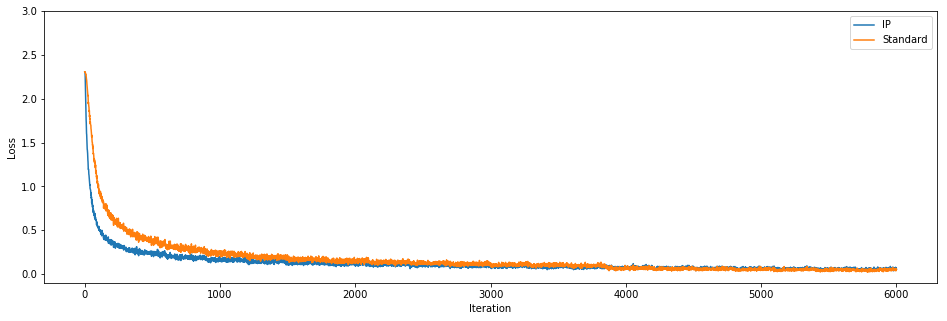

In [7]:
syn_lr = 0.001

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.567
[2] loss: 0.246
[3] loss: 0.192
[4] loss: 0.161
[5] loss: 0.142
[6] loss: 0.127
[7] loss: 0.118
[8] loss: 0.108
[9] loss: 0.101
[10] loss: 0.092
[11] loss: 0.087
[12] loss: 0.082
[13] loss: 0.079
[14] loss: 0.074
[15] loss: 0.069
[16] loss: 0.068
[17] loss: 0.063
[18] loss: 0.064
[19] loss: 0.057
[20] loss: 0.057
Largest beta is  (tensor(0.5546, device='cuda:0'), tensor(39, device='cuda:0'))
Largest weight is  (tensor(1.8197, device='cuda:0'), tensor(247, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 1.308
[2] loss: 0.492
[3] loss: 0.294
[4] loss: 0.203
[5] loss: 0.156
[6] loss: 0.141
[7] loss: 0.119
[8] loss: 0.106
[9] loss: 0.097
[10] loss: 0.092
[11] loss: 0.086
[12] loss: 0.082
[13] loss: 0.076
[14] loss: 0.074
[15] loss: 0.070
[16] loss: 0.070
[17] loss: 0.062
[18] loss: 0.061
[19] loss: 0.058
[20] loss: 0.056
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(1

[8] loss: 0.104
[9] loss: 0.095
[10] loss: 0.085
[11] loss: 0.084
[12] loss: 0.080
[13] loss: 0.073
[14] loss: 0.073
[15] loss: 0.065
[16] loss: 0.070
[17] loss: 0.066
[18] loss: 0.062
[19] loss: 0.060
[20] loss: 0.059
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(1.8416, device='cuda:0'), tensor(288, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 0.438
[2] loss: 0.203
[3] loss: 0.164
[4] loss: 0.141
[5] loss: 0.127
[6] loss: 0.117
[7] loss: 0.107
[8] loss: 0.099
[9] loss: 0.094
[10] loss: 0.086
[11] loss: 0.081
[12] loss: 0.080
[13] loss: 0.073
[14] loss: 0.069
[15] loss: 0.066
[16] loss: 0.063
[17] loss: 0.059
[18] loss: 0.059
[19] loss: 0.054
[20] loss: 0.052
Largest beta is  (tensor(0.5715, device='cuda:0'), tensor(22, device='cuda:0'))
Largest weight is  (tensor(1.3192, device='cuda:0'), tensor(134, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 1.088
[2] loss: 0.385
[3] l

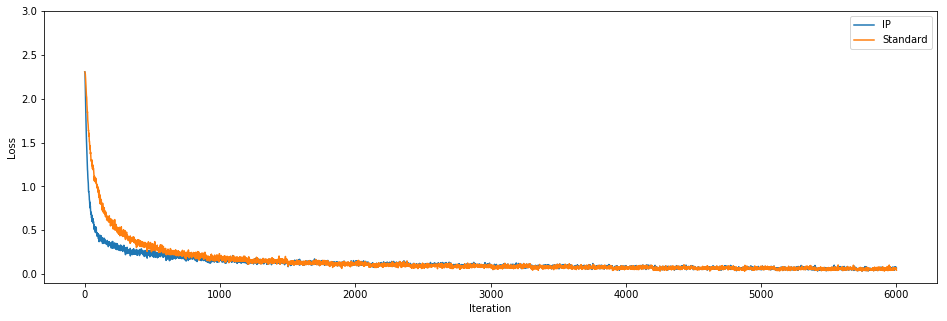

In [8]:
syn_lr = 0.003

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.564
[2] loss: 0.277
[3] loss: 0.215
[4] loss: 0.176
[5] loss: 0.159
[6] loss: 0.143
[7] loss: 0.131
[8] loss: 0.121
[9] loss: 0.113
[10] loss: 0.105
[11] loss: 0.100
[12] loss: 0.097
[13] loss: 0.091
[14] loss: 0.087
[15] loss: 0.083
[16] loss: 0.081
[17] loss: 0.079
[18] loss: 0.072
[19] loss: 0.070
[20] loss: 0.068
Largest beta is  (tensor(0.5634, device='cuda:0'), tensor(44, device='cuda:0'))
Largest weight is  (tensor(5.4125, device='cuda:0'), tensor(371, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 0.742
[2] loss: 0.388
[3] loss: 0.349
[4] loss: 0.318
[5] loss: 0.291
[6] loss: 0.300
[7] loss: 0.322
[8] loss: 0.291
[9] loss: 0.307
[10] loss: 0.348
[11] loss: 0.343
[12] loss: 0.323
[13] loss: 0.348
[14] loss: 0.331
[15] loss: 0.344
[16] loss: 0.353
[17] loss: 0.403
[18] loss: 0.405
[19] loss: 0.388
[20] loss: 0.356
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(4

[8] loss: 2.310
[9] loss: 2.310
[10] loss: 2.310
[11] loss: 2.310
[12] loss: 2.310
[13] loss: 2.310
[14] loss: 2.310
[15] loss: 2.310
[16] loss: 2.310
[17] loss: 2.310
[18] loss: 2.310
[19] loss: 2.310
[20] loss: 2.310
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.6174, device='cuda:0'), tensor(25, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 0.520
[2] loss: 0.257
[3] loss: 0.201
[4] loss: 0.176
[5] loss: 0.153
[6] loss: 0.138
[7] loss: 0.129
[8] loss: 0.121
[9] loss: 0.112
[10] loss: 0.107
[11] loss: 0.099
[12] loss: 0.097
[13] loss: 0.091
[14] loss: 0.087
[15] loss: 0.081
[16] loss: 0.082
[17] loss: 0.077
[18] loss: 0.075
[19] loss: 0.072
[20] loss: 0.068
Largest beta is  (tensor(0.5581, device='cuda:0'), tensor(12, device='cuda:0'))
Largest weight is  (tensor(5.1197, device='cuda:0'), tensor(540, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 0.824
[2] loss: 0.428
[3] lo

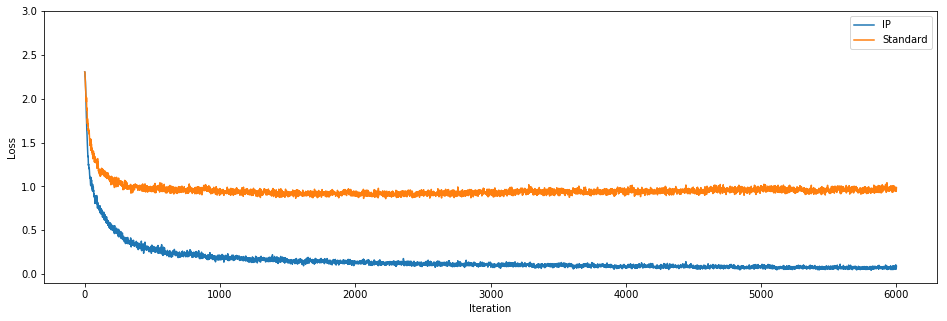

In [9]:
syn_lr = 0.01

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 0.905
[2] loss: 0.320
[3] loss: 0.241
[4] loss: 0.196
[5] loss: 0.173
[6] loss: 0.160
[7] loss: 0.144
[8] loss: 0.135
[9] loss: 0.127
[10] loss: 0.119
[11] loss: 0.112
[12] loss: 0.106
[13] loss: 0.102
[14] loss: 0.096
[15] loss: 0.092
[16] loss: 0.087
[17] loss: 0.086
[18] loss: 0.081
[19] loss: 0.081
[20] loss: 0.076
Largest beta is  (tensor(0.5666, device='cuda:0'), tensor(29, device='cuda:0'))
Largest weight is  (tensor(9.6926, device='cuda:0'), tensor(331, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 1.829
[2] loss: 2.235
[3] loss: 2.310
[4] loss: 2.310
[5] loss: 2.310
[6] loss: 2.310
[7] loss: 2.310
[8] loss: 2.310
[9] loss: 2.310
[10] loss: 2.310
[11] loss: 2.310
[12] loss: 2.310
[13] loss: 2.310
[14] loss: 2.310
[15] loss: 2.310
[16] loss: 2.310
[17] loss: 2.310
[18] loss: 2.310
[19] loss: 2.310
[20] loss: 2.310
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(1

[8] loss: 2.310
[9] loss: 2.310
[10] loss: 2.310
[11] loss: 2.310
[12] loss: 2.310
[13] loss: 2.310
[14] loss: 2.310
[15] loss: 2.310
[16] loss: 2.310
[17] loss: 2.310
[18] loss: 2.310
[19] loss: 2.310
[20] loss: 2.310
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.5338, device='cuda:0'), tensor(22, device='cuda:0'))
Finished training!

Training IP Net. Run 9
[1] loss: 0.680
[2] loss: 0.329
[3] loss: 0.243
[4] loss: 0.202
[5] loss: 0.174
[6] loss: 0.155
[7] loss: 0.143
[8] loss: 0.134
[9] loss: 0.124
[10] loss: 0.114
[11] loss: 0.113
[12] loss: 0.108
[13] loss: 0.101
[14] loss: 0.094
[15] loss: 0.096
[16] loss: 0.091
[17] loss: 0.084
[18] loss: 0.084
[19] loss: 0.080
[20] loss: 0.080
Largest beta is  (tensor(0.5651, device='cuda:0'), tensor(6, device='cuda:0'))
Largest weight is  (tensor(8.4873, device='cuda:0'), tensor(719, device='cuda:0'))
Finished training!

Training Standard Net. Run 9
[1] loss: 1.257
[2] loss: 1.169
[3] los

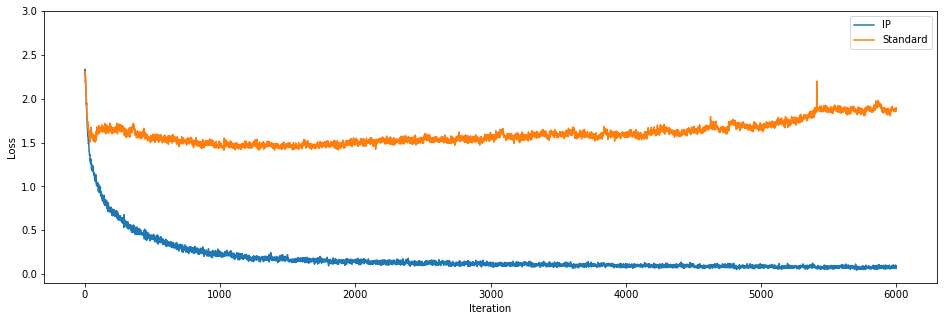

In [10]:
syn_lr = 0.015

run_mnist_experiment(int_lr, syn_lr, epochs, test_runs)

# CIFAR-10 Tests

In [11]:
batchSize = 200

transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LAYERSIZE = 150
epochs = 40

test_runs = 10

int_lr = 0.1

Training IP Net. Run 1
[1] loss: 1.955
[2] loss: 1.839
[3] loss: 1.768
[4] loss: 1.733
[5] loss: 1.690
[6] loss: 1.671
[7] loss: 1.650
[8] loss: 1.628
[9] loss: 1.604
[10] loss: 1.576
[11] loss: 1.561
[12] loss: 1.549
[13] loss: 1.523
[14] loss: 1.506
[15] loss: 1.483
[16] loss: 1.474
[17] loss: 1.459
[18] loss: 1.444
[19] loss: 1.433
[20] loss: 1.421
[21] loss: 1.416
[22] loss: 1.396
[23] loss: 1.382
[24] loss: 1.366
[25] loss: 1.363
[26] loss: 1.349
[27] loss: 1.338
[28] loss: 1.339
[29] loss: 1.331
[30] loss: 1.306
[31] loss: 1.288
[32] loss: 1.283
[33] loss: 1.270
[34] loss: 1.254
[35] loss: 1.250
[36] loss: 1.236
[37] loss: 1.224
[38] loss: 1.216
[39] loss: 1.210
[40] loss: 1.199
Largest beta is  (tensor(0.6213, device='cuda:0'), tensor(50, device='cuda:0'))
Largest weight is  (tensor(0.3066, device='cuda:0'), tensor(55, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.071
[2] loss: 1.880
[3] loss: 1.791
[4] loss: 1.719
[5] loss: 1.679
[6] loss: 1.630

[18] loss: 1.342
[19] loss: 1.317
[20] loss: 1.302
[21] loss: 1.288
[22] loss: 1.282
[23] loss: 1.262
[24] loss: 1.254
[25] loss: 1.234
[26] loss: 1.226
[27] loss: 1.205
[28] loss: 1.203
[29] loss: 1.194
[30] loss: 1.192
[31] loss: 1.161
[32] loss: 1.158
[33] loss: 1.145
[34] loss: 1.141
[35] loss: 1.126
[36] loss: 1.115
[37] loss: 1.101
[38] loss: 1.091
[39] loss: 1.088
[40] loss: 1.072
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.3117, device='cuda:0'), tensor(83, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 1.958
[2] loss: 1.845
[3] loss: 1.770
[4] loss: 1.727
[5] loss: 1.708
[6] loss: 1.685
[7] loss: 1.669
[8] loss: 1.636
[9] loss: 1.612
[10] loss: 1.595
[11] loss: 1.567
[12] loss: 1.555
[13] loss: 1.537
[14] loss: 1.520
[15] loss: 1.500
[16] loss: 1.484
[17] loss: 1.464
[18] loss: 1.452
[19] loss: 1.433
[20] loss: 1.414
[21] loss: 1.409
[22] loss: 1.397
[23] loss: 1.387
[24] loss: 1.364
[25] loss:

[37] loss: 1.206
[38] loss: 1.192
[39] loss: 1.187
[40] loss: 1.178
Largest beta is  (tensor(0.6209, device='cuda:0'), tensor(35, device='cuda:0'))
Largest weight is  (tensor(0.3406, device='cuda:0'), tensor(142, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.060
[2] loss: 1.857
[3] loss: 1.780
[4] loss: 1.724
[5] loss: 1.667
[6] loss: 1.625
[7] loss: 1.584
[8] loss: 1.550
[9] loss: 1.521
[10] loss: 1.497
[11] loss: 1.470
[12] loss: 1.443
[13] loss: 1.426
[14] loss: 1.403
[15] loss: 1.385
[16] loss: 1.369
[17] loss: 1.346
[18] loss: 1.342
[19] loss: 1.320
[20] loss: 1.304
[21] loss: 1.291
[22] loss: 1.277
[23] loss: 1.266
[24] loss: 1.250
[25] loss: 1.238
[26] loss: 1.221
[27] loss: 1.211
[28] loss: 1.211
[29] loss: 1.193
[30] loss: 1.191
[31] loss: 1.174
[32] loss: 1.165
[33] loss: 1.154
[34] loss: 1.135
[35] loss: 1.119
[36] loss: 1.117
[37] loss: 1.109
[38] loss: 1.096
[39] loss: 1.088
[40] loss: 1.081
Largest beta is  (tensor(0., device='cuda:0'), t

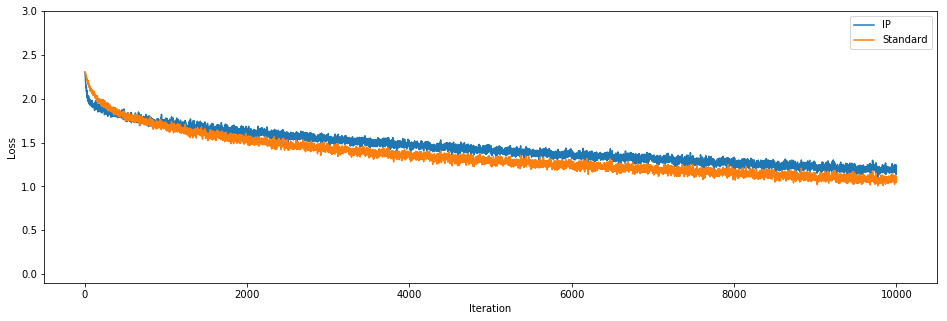

In [13]:
syn_lr = 0.0003

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 1.983
[2] loss: 1.844
[3] loss: 1.779
[4] loss: 1.740
[5] loss: 1.691
[6] loss: 1.658
[7] loss: 1.634
[8] loss: 1.606
[9] loss: 1.580
[10] loss: 1.557
[11] loss: 1.536
[12] loss: 1.509
[13] loss: 1.493
[14] loss: 1.478
[15] loss: 1.460
[16] loss: 1.441
[17] loss: 1.425
[18] loss: 1.409
[19] loss: 1.394
[20] loss: 1.377
[21] loss: 1.364
[22] loss: 1.350
[23] loss: 1.338
[24] loss: 1.321
[25] loss: 1.310
[26] loss: 1.296
[27] loss: 1.283
[28] loss: 1.275
[29] loss: 1.263
[30] loss: 1.249
[31] loss: 1.237
[32] loss: 1.226
[33] loss: 1.216
[34] loss: 1.208
[35] loss: 1.196
[36] loss: 1.188
[37] loss: 1.180
[38] loss: 1.165
[39] loss: 1.156
[40] loss: 1.147
Largest beta is  (tensor(0.6196, device='cuda:0'), tensor(40, device='cuda:0'))
Largest weight is  (tensor(0.4733, device='cuda:0'), tensor(134, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.021
[2] loss: 1.838
[3] loss: 1.777
[4] loss: 1.715
[5] loss: 1.679
[6] loss: 1.63

[18] loss: 1.385
[19] loss: 1.370
[20] loss: 1.353
[21] loss: 1.339
[22] loss: 1.329
[23] loss: 1.313
[24] loss: 1.301
[25] loss: 1.299
[26] loss: 1.292
[27] loss: 1.270
[28] loss: 1.259
[29] loss: 1.255
[30] loss: 1.244
[31] loss: 1.234
[32] loss: 1.227
[33] loss: 1.207
[34] loss: 1.200
[35] loss: 1.187
[36] loss: 1.183
[37] loss: 1.182
[38] loss: 1.165
[39] loss: 1.148
[40] loss: 1.149
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.3570, device='cuda:0'), tensor(105, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 1.961
[2] loss: 1.834
[3] loss: 1.767
[4] loss: 1.716
[5] loss: 1.664
[6] loss: 1.630
[7] loss: 1.606
[8] loss: 1.574
[9] loss: 1.553
[10] loss: 1.524
[11] loss: 1.512
[12] loss: 1.493
[13] loss: 1.476
[14] loss: 1.461
[15] loss: 1.440
[16] loss: 1.422
[17] loss: 1.401
[18] loss: 1.391
[19] loss: 1.371
[20] loss: 1.354
[21] loss: 1.339
[22] loss: 1.326
[23] loss: 1.314
[24] loss: 1.302
[25] loss

[36] loss: 1.180
[37] loss: 1.171
[38] loss: 1.166
[39] loss: 1.154
[40] loss: 1.148
Largest beta is  (tensor(0.6187, device='cuda:0'), tensor(2, device='cuda:0'))
Largest weight is  (tensor(0.5419, device='cuda:0'), tensor(49, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.312
[2] loss: 2.312
[3] loss: 2.312
[4] loss: 2.312
[5] loss: 2.312
[6] loss: 2.312
[7] loss: 2.312
[8] loss: 2.312
[9] loss: 2.312
[10] loss: 2.312
[11] loss: 2.312
[12] loss: 2.312
[13] loss: 2.312
[14] loss: 2.312
[15] loss: 2.312
[16] loss: 2.312
[17] loss: 2.312
[18] loss: 2.312
[19] loss: 2.312
[20] loss: 2.312
[21] loss: 2.312
[22] loss: 2.312
[23] loss: 2.312
[24] loss: 2.312
[25] loss: 2.312
[26] loss: 2.312
[27] loss: 2.312
[28] loss: 2.312
[29] loss: 2.312
[30] loss: 2.312
[31] loss: 2.312
[32] loss: 2.312
[33] loss: 2.312
[34] loss: 2.312
[35] loss: 2.312
[36] loss: 2.312
[37] loss: 2.312
[38] loss: 2.312
[39] loss: 2.312
[40] loss: 2.312
Largest beta is  (tensor(0., devi

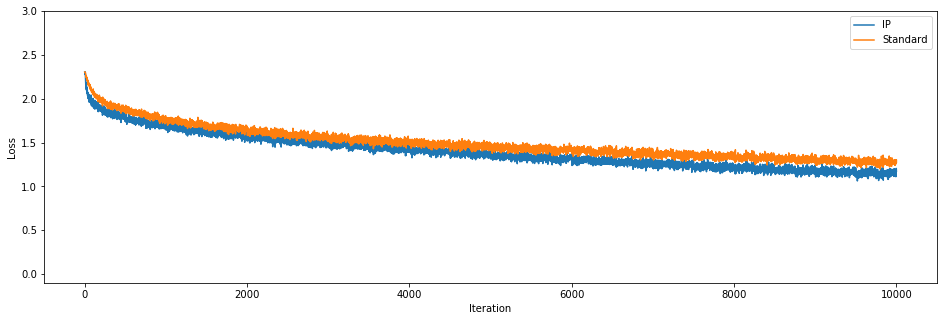

In [14]:
syn_lr = 0.0006

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 1.972
[2] loss: 1.830
[3] loss: 1.791
[4] loss: 1.734
[5] loss: 1.687
[6] loss: 1.647
[7] loss: 1.616
[8] loss: 1.593
[9] loss: 1.564
[10] loss: 1.545
[11] loss: 1.520
[12] loss: 1.502
[13] loss: 1.486
[14] loss: 1.465
[15] loss: 1.454
[16] loss: 1.430
[17] loss: 1.422
[18] loss: 1.401
[19] loss: 1.387
[20] loss: 1.371
[21] loss: 1.356
[22] loss: 1.342
[23] loss: 1.328
[24] loss: 1.314
[25] loss: 1.300
[26] loss: 1.294
[27] loss: 1.273
[28] loss: 1.265
[29] loss: 1.255
[30] loss: 1.244
[31] loss: 1.230
[32] loss: 1.221
[33] loss: 1.210
[34] loss: 1.197
[35] loss: 1.189
[36] loss: 1.181
[37] loss: 1.172
[38] loss: 1.163
[39] loss: 1.154
[40] loss: 1.142
Largest beta is  (tensor(0.5997, device='cuda:0'), tensor(12, device='cuda:0'))
Largest weight is  (tensor(0.6865, device='cuda:0'), tensor(105, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.056
[2] loss: 1.914
[3] loss: 1.844
[4] loss: 1.802
[5] loss: 1.764
[6] loss: 1.73

[17] loss: 1.533
[18] loss: 1.523
[19] loss: 1.527
[20] loss: 1.509
[21] loss: 1.505
[22] loss: 1.493
[23] loss: 1.486
[24] loss: 1.481
[25] loss: 1.479
[26] loss: 1.456
[27] loss: 1.457
[28] loss: 1.456
[29] loss: 1.438
[30] loss: 1.448
[31] loss: 1.426
[32] loss: 1.421
[33] loss: 1.421
[34] loss: 1.399
[35] loss: 1.401
[36] loss: 1.393
[37] loss: 1.377
[38] loss: 1.383
[39] loss: 1.376
[40] loss: 1.369
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(0.6275, device='cuda:0'), tensor(89, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.012
[2] loss: 1.852
[3] loss: 1.793
[4] loss: 1.742
[5] loss: 1.689
[6] loss: 1.650
[7] loss: 1.617
[8] loss: 1.588
[9] loss: 1.568
[10] loss: 1.546
[11] loss: 1.525
[12] loss: 1.504
[13] loss: 1.485
[14] loss: 1.467
[15] loss: 1.445
[16] loss: 1.429
[17] loss: 1.411
[18] loss: 1.393
[19] loss: 1.375
[20] loss: 1.365
[21] loss: 1.347
[22] loss: 1.335
[23] loss: 1.321
[24] loss:

[36] loss: 1.195
[37] loss: 1.185
[38] loss: 1.182
[39] loss: 1.169
[40] loss: 1.160
Largest beta is  (tensor(0.6286, device='cuda:0'), tensor(84, device='cuda:0'))
Largest weight is  (tensor(0.6847, device='cuda:0'), tensor(25, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.312
[2] loss: 2.312
[3] loss: 2.312
[4] loss: 2.312
[5] loss: 2.312
[6] loss: 2.312
[7] loss: 2.312
[8] loss: 2.312
[9] loss: 2.312
[10] loss: 2.312
[11] loss: 2.312
[12] loss: 2.312
[13] loss: 2.312
[14] loss: 2.312
[15] loss: 2.312
[16] loss: 2.312
[17] loss: 2.312
[18] loss: 2.312
[19] loss: 2.312
[20] loss: 2.312
[21] loss: 2.312
[22] loss: 2.312
[23] loss: 2.312
[24] loss: 2.312
[25] loss: 2.312
[26] loss: 2.312
[27] loss: 2.312
[28] loss: 2.312
[29] loss: 2.312
[30] loss: 2.312
[31] loss: 2.312
[32] loss: 2.312
[33] loss: 2.312
[34] loss: 2.312
[35] loss: 2.312
[36] loss: 2.312
[37] loss: 2.312
[38] loss: 2.312
[39] loss: 2.312
[40] loss: 2.312
Largest beta is  (tensor(0., dev

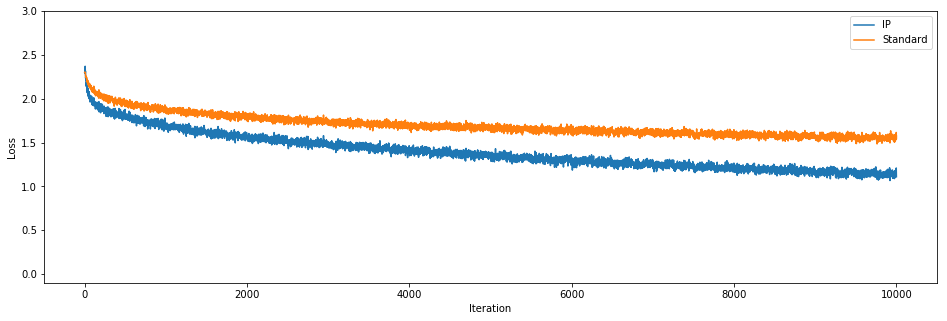

In [15]:
syn_lr = 0.001
run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)

Training IP Net. Run 1
[1] loss: 2.042
[2] loss: 1.897
[3] loss: 1.826
[4] loss: 1.771
[5] loss: 1.728
[6] loss: 1.686
[7] loss: 1.650
[8] loss: 1.619
[9] loss: 1.589
[10] loss: 1.565
[11] loss: 1.537
[12] loss: 1.513
[13] loss: 1.487
[14] loss: 1.474
[15] loss: 1.449
[16] loss: 1.436
[17] loss: 1.416
[18] loss: 1.402
[19] loss: 1.388
[20] loss: 1.377
[21] loss: 1.357
[22] loss: 1.347
[23] loss: 1.335
[24] loss: 1.326
[25] loss: 1.310
[26] loss: 1.299
[27] loss: 1.282
[28] loss: 1.276
[29] loss: 1.266
[30] loss: 1.259
[31] loss: 1.244
[32] loss: 1.236
[33] loss: 1.233
[34] loss: 1.214
[35] loss: 1.205
[36] loss: 1.197
[37] loss: 1.192
[38] loss: 1.182
[39] loss: 1.177
[40] loss: 1.161
Largest beta is  (tensor(0.6013, device='cuda:0'), tensor(32, device='cuda:0'))
Largest weight is  (tensor(1.2183, device='cuda:0'), tensor(98, device='cuda:0'))
Finished training!

Training Standard Net. Run 1
[1] loss: 2.172
[2] loss: 2.101
[3] loss: 2.093
[4] loss: 2.067
[5] loss: 2.060
[6] loss: 2.056

[18] loss: 2.042
[19] loss: 2.023
[20] loss: 2.027
[21] loss: 2.036
[22] loss: 2.051
[23] loss: 2.138
[24] loss: 2.312
[25] loss: 2.312
[26] loss: 2.312
[27] loss: 2.312
[28] loss: 2.312
[29] loss: 2.312
[30] loss: 2.312
[31] loss: 2.312
[32] loss: 2.312
[33] loss: 2.312
[34] loss: 2.312
[35] loss: 2.312
[36] loss: 2.312
[37] loss: 2.312
[38] loss: 2.312
[39] loss: 2.312
[40] loss: 2.312
Largest beta is  (tensor(0., device='cuda:0'), tensor(0, device='cuda:0'))
Largest weight is  (tensor(1.2640, device='cuda:0'), tensor(52, device='cuda:0'))
Finished training!

Training IP Net. Run 6
[1] loss: 2.043
[2] loss: 1.874
[3] loss: 1.799
[4] loss: 1.754
[5] loss: 1.721
[6] loss: 1.688
[7] loss: 1.648
[8] loss: 1.622
[9] loss: 1.589
[10] loss: 1.569
[11] loss: 1.540
[12] loss: 1.510
[13] loss: 1.495
[14] loss: 1.479
[15] loss: 1.455
[16] loss: 1.437
[17] loss: 1.425
[18] loss: 1.411
[19] loss: 1.393
[20] loss: 1.381
[21] loss: 1.362
[22] loss: 1.352
[23] loss: 1.332
[24] loss: 1.328
[25] loss:

[37] loss: 1.191
[38] loss: 1.181
[39] loss: 1.167
[40] loss: 1.166
Largest beta is  (tensor(0.6090, device='cuda:0'), tensor(142, device='cuda:0'))
Largest weight is  (tensor(1.1604, device='cuda:0'), tensor(71, device='cuda:0'))
Finished training!

Training Standard Net. Run 10
[1] loss: 2.145
[2] loss: 2.085
[3] loss: 2.053
[4] loss: 2.018
[5] loss: 1.988
[6] loss: 1.984
[7] loss: 1.990
[8] loss: 1.984
[9] loss: 1.989
[10] loss: 1.985
[11] loss: 1.959
[12] loss: 2.028
[13] loss: 1.965
[14] loss: 1.954
[15] loss: 1.984
[16] loss: 2.027
[17] loss: 2.005
[18] loss: 2.047
[19] loss: 2.076
[20] loss: 2.258
[21] loss: 2.314
[22] loss: 2.312
[23] loss: 2.312
[24] loss: 2.312
[25] loss: 2.312
[26] loss: 2.312
[27] loss: 2.312
[28] loss: 2.312
[29] loss: 2.312
[30] loss: 2.312
[31] loss: 2.312
[32] loss: 2.312
[33] loss: 2.312
[34] loss: 2.312
[35] loss: 2.312
[36] loss: 2.312
[37] loss: 2.312
[38] loss: 2.312
[39] loss: 2.312
[40] loss: 2.312
Largest beta is  (tensor(0., device='cuda:0'), t

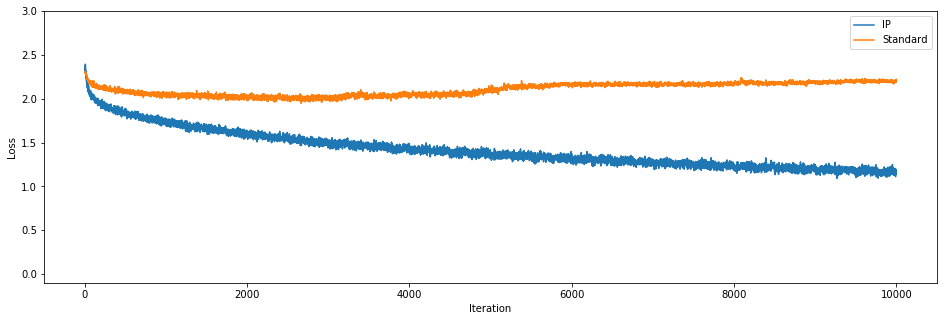

In [16]:
syn_lr = 0.002

run_cifar_experiment(int_lr, syn_lr, epochs, test_runs)